# German Credit Case Study

## Problem Statement


### Context
To minimize loss from the bank’s perspective, the bank needs a decision rule regarding whom to approve the loan and whom not to. An applicant’s demographic and socio-economic profiles are considered by loan managers before a decision is taken regarding his/her loan application. In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as a good or bad credit risk according to the set of attributes.


### Objective:
The objective is to build a predictive model on this data to help the bank decide on whether to approve a loan to a prospective applicant.


### Dataset:
* Age (Numeric: Age in years)
* Sex (Categories: male, female)
* Job (Categories: unskilled and non-resident, unskilled and resident, skilled, highly skilled)
* Housing (Categories: own, rent, or free)
* Saving accounts (Categories: little, moderate, quite rich, rich)
* Checking account (Categories: little, moderate, rich)
* Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
* Duration (Numeric: Duration for which the credit is given in months)
* Purpose (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
* Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))


## Import Important Liraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)


# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To tune different models
from sklearn.model_selection import GridSearchCV

In [2]:
credit = pd.read_csv("https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/German_Credit.csv")

In [3]:
# copying data to another variable to avoid any changes to original data
data = credit.copy()

## Overview of the dataset

### View first and last few rows of the Dataset

In [4]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
0,67,male,skilled,own,little,little,1169,6,0,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,1,radio/TV
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
3,45,male,skilled,free,little,little,7882,42,0,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,1,car


In [5]:
data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
995,31,female,unskilled_and_non-resident,own,little,little,1736,12,0,furniture/equipment
996,40,male,highly skilled,own,little,little,3857,30,0,car
997,38,male,skilled,own,little,little,804,12,0,radio/TV
998,23,male,skilled,free,little,little,1845,45,1,radio/TV
999,27,male,skilled,own,moderate,moderate,4576,45,0,car


### Understand the shape of the dataset

In [6]:
# Get the shape of the DataFrame (rows, columns)
rows, columns = data.shape

# Print the number of rows and columns
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 1000
Number of columns: 10


### Check the data types of the columns for the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [8]:
# checking for duplicate values
data.duplicated().sum()

np.int64(0)

## Exploratory Data Analysis

In [9]:
data.describe()

,Age,Credit amount,Duration,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000,0.300000
std,11.375469,2822.736876,12.058814,0.458487
min,19.000000,250.000000,4.000000,0.000000
25%,27.000000,1365.500000,12.000000,0.000000
50%,33.000000,2319.500000,18.000000,0.000000
75%,42.000000,3972.250000,24.000000,1.000000
max,75.000000,18424.000000,72.000000,1.000000


#### Let's check the count of each unique category in each of the categorical variables

In [10]:
# Making a list of all catrgorical variables
cat_col = list(data.select_dtypes("object").columns)

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 50)

Sex
male      690
female    310
Name: count, dtype: int64
--------------------------------------------------
Job
skilled                       630
unskilled_and_non-resident    222
highly skilled                148
Name: count, dtype: int64
--------------------------------------------------
Housing
own     713
rent    179
free    108
Name: count, dtype: int64
--------------------------------------------------
Saving accounts
little        786
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64
--------------------------------------------------
Checking account
moderate    472
little      465
rich         63
Name: count, dtype: int64
--------------------------------------------------
Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64
------------------------------

## Univariate Analysis

In [11]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Observations on Age feature

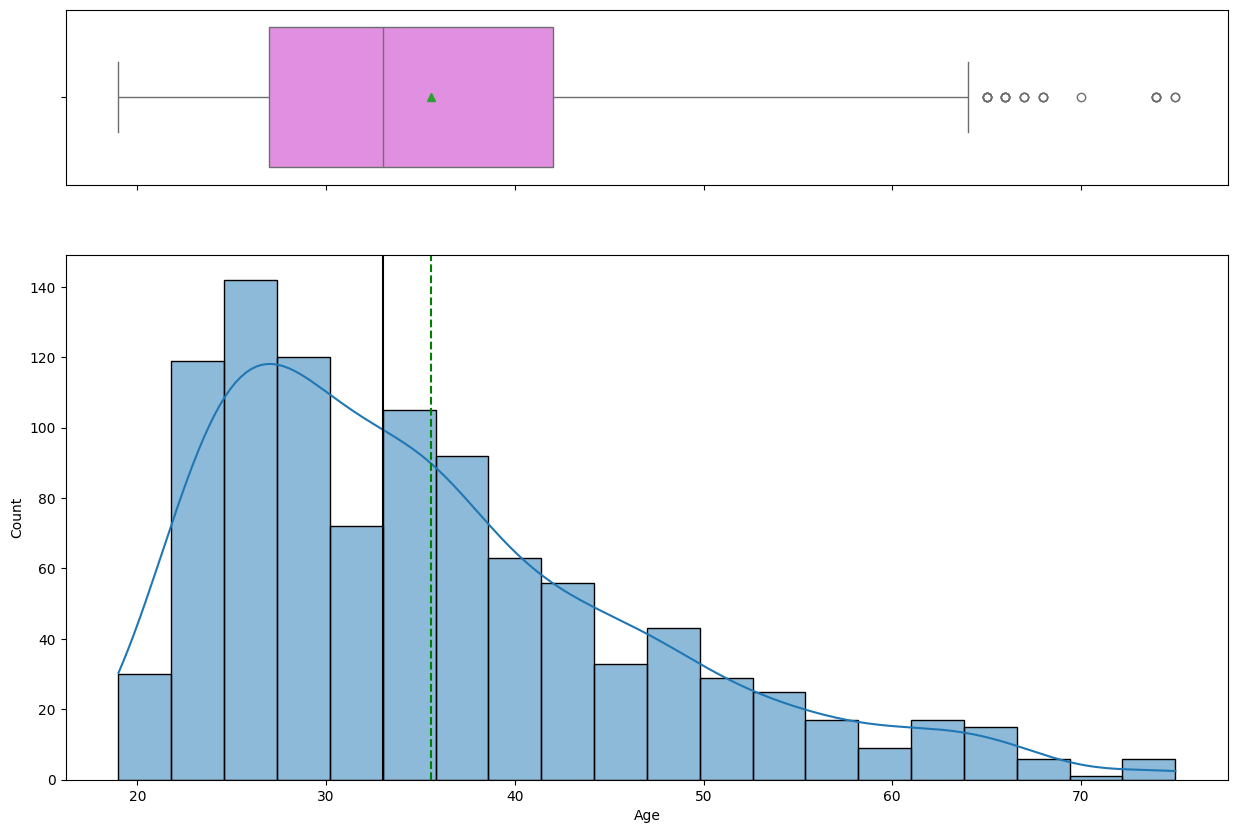

In [12]:
histogram_boxplot(data, 'Age', kde=True, bins=20)

### Observations on Credit amount feature

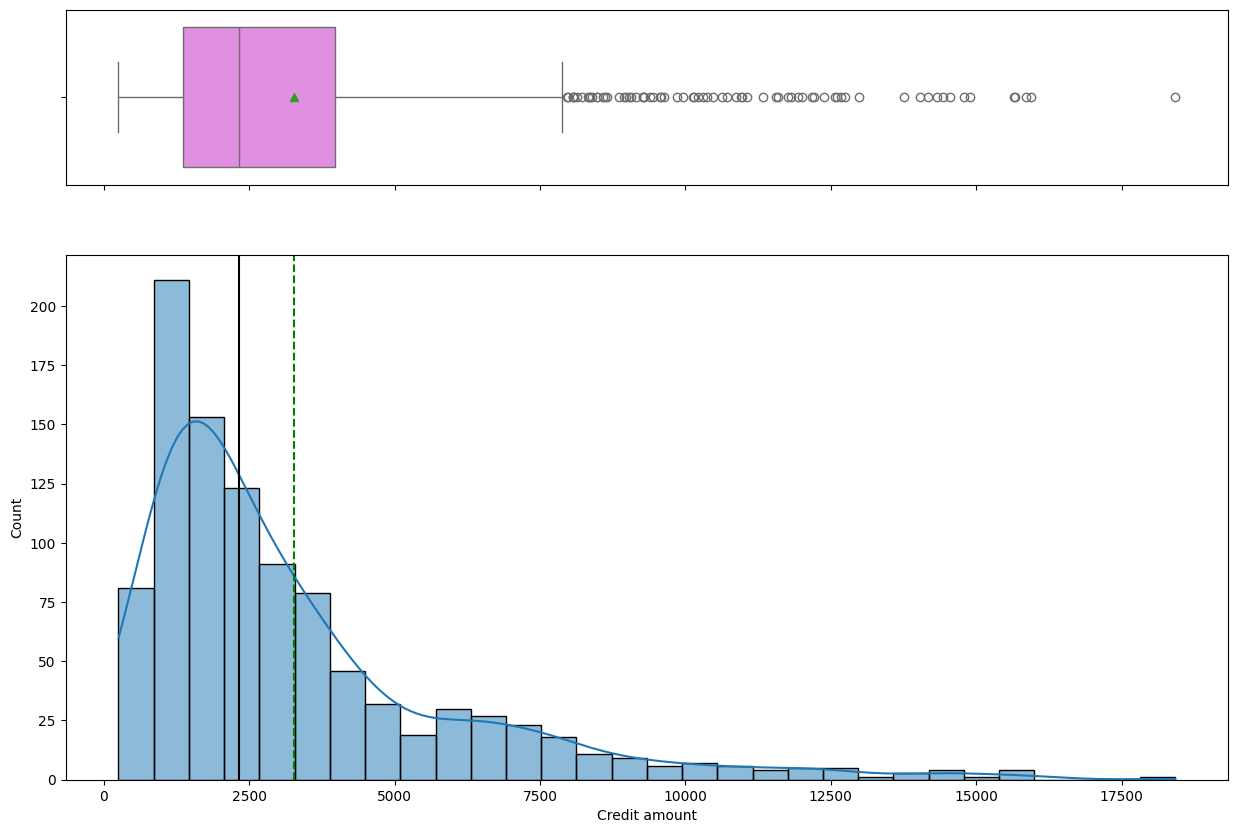

In [13]:
histogram_boxplot(data, 'Credit amount', kde=True, bins=30)

### Observations on Duration feature

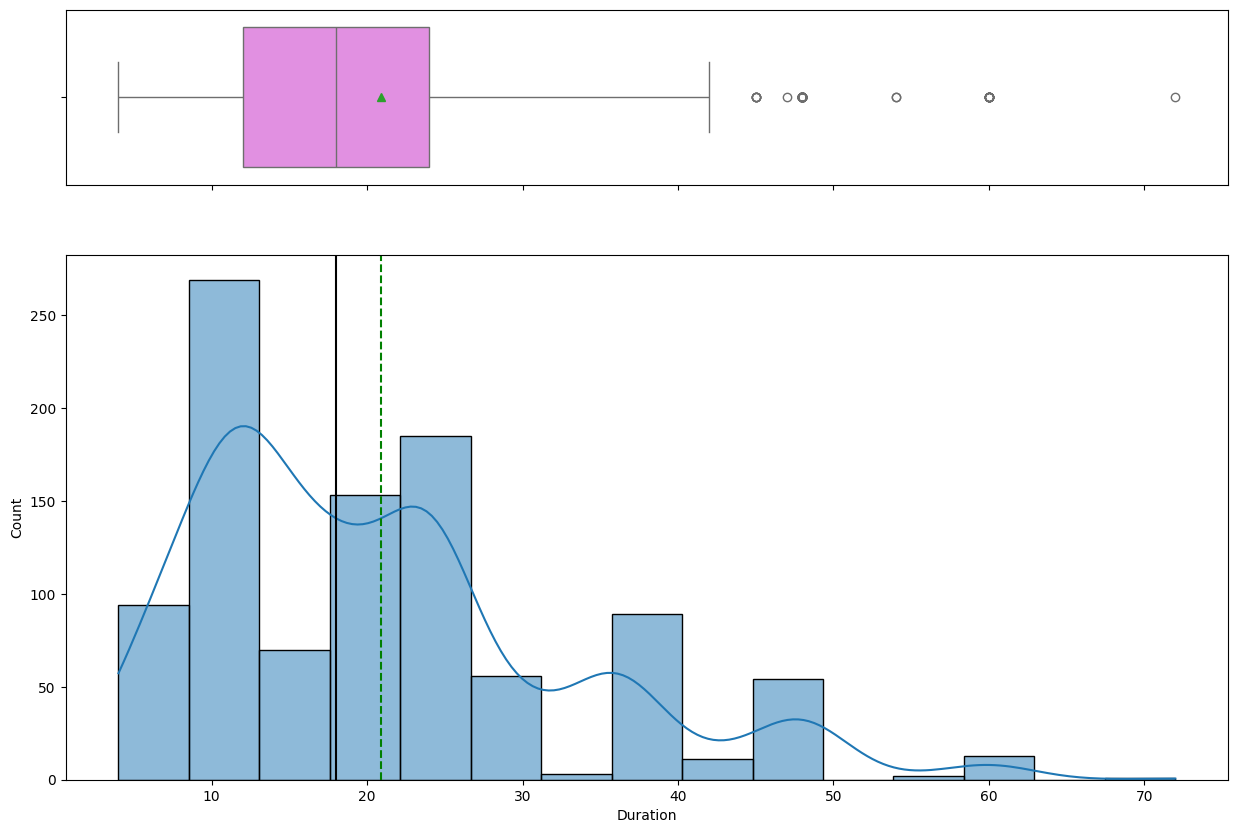

In [14]:
histogram_boxplot(data, 'Duration', kde=True, bins=15)

## Insights from Histogram and Boxplot Visualizations:

### 1. Age:

* Distribution: The age distribution is right-skewed, meaning there is a higher concentration of younger individuals (between 25 and 40 years old), while fewer individuals are older (above 50 years).
* Outliers: There are some outliers on the higher end (ages above 60), which may or may not be significant depending on the dataset's context.
### Action:

You could consider scaling or normalizing this variable due to the skewness.
If the outliers are rare or inconsistent with the rest of the data, it may be worth considering removing them or treating them differently. Alternatively, you can test the model performance with and without these outliers.

### 2. Credit Amount:

* Distribution: This feature is strongly right-skewed with a heavy concentration of credit amounts under 5,000 DM, but some extreme values as high as 18,000 DM. This kind of distribution can cause issues with certain machine learning algorithms (like linear regression) as they assume normally distributed data.
* Outliers: The boxplot shows several outliers for high credit amounts, which could represent a different customer profile or loan type.
### Action:

You may consider applying a log transformation to make the distribution more symmetrical, which could improve model performance, especially for algorithms sensitive to skewness.
Evaluate if the outliers are valid or if they should be capped (using techniques like winsorization) or treated differently to reduce their impact on model training.
### 3. Duration:

* Distribution: The distribution is somewhat bimodal, with peaks around 12 months and 24 months. There is a spread of durations with outliers above 50 months. This indicates the presence of two distinct groups, one taking shorter loans and another taking longer loans.
* Outliers: Durations longer than 50 months appear as outliers, which might require further investigation.
#### Action:

Consider splitting this variable into categories (e.g., short-term, medium-term, long-term loans) if the durations correspond to different types of customers or loans. This will simplify modeling and might enhance the model's interpretability.
You can also investigate further whether these outliers represent a meaningful distinction in customer behavior.

In [15]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Observations on Job feature

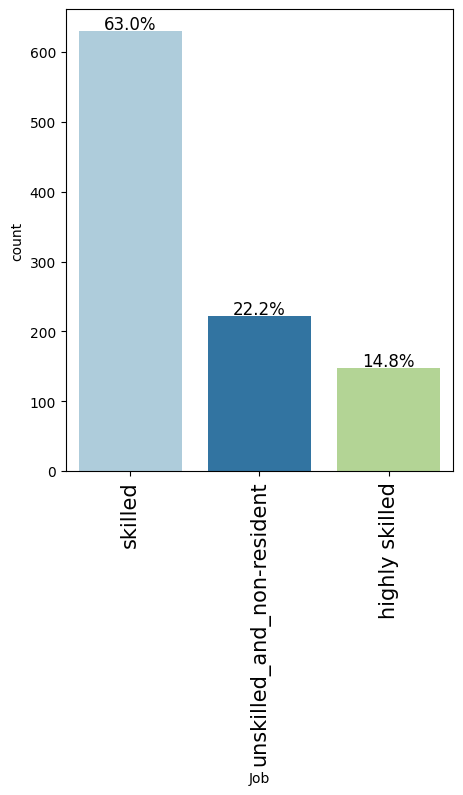

In [16]:
labeled_barplot(data, feature="Job", perc=True)

### Observations on Housing feature

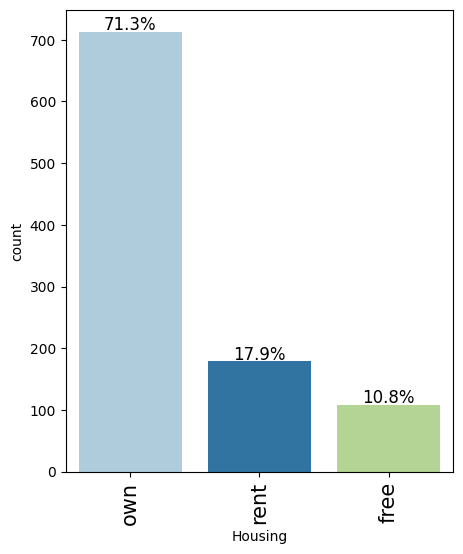

In [17]:
labeled_barplot(data, feature="Housing", perc=True)

### Observations on Purpose feature

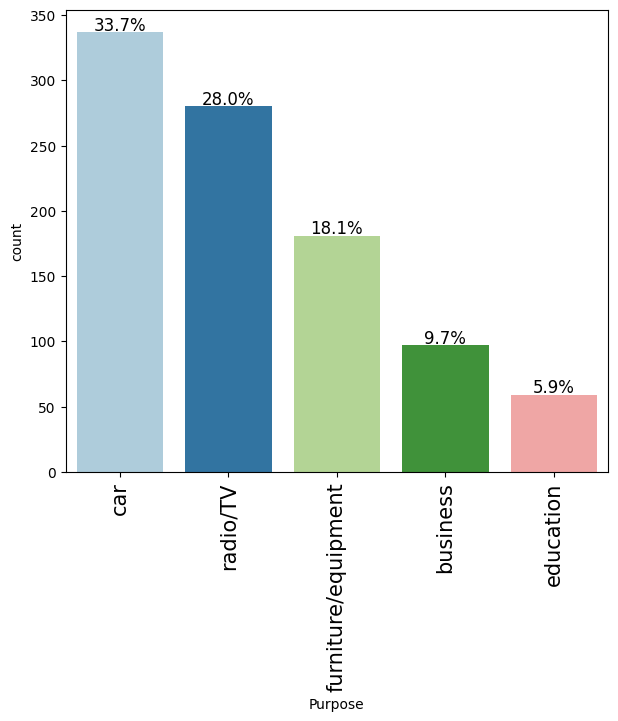

In [18]:
labeled_barplot(data, feature="Purpose", perc=True, n=5)

### Bivariate Analysis

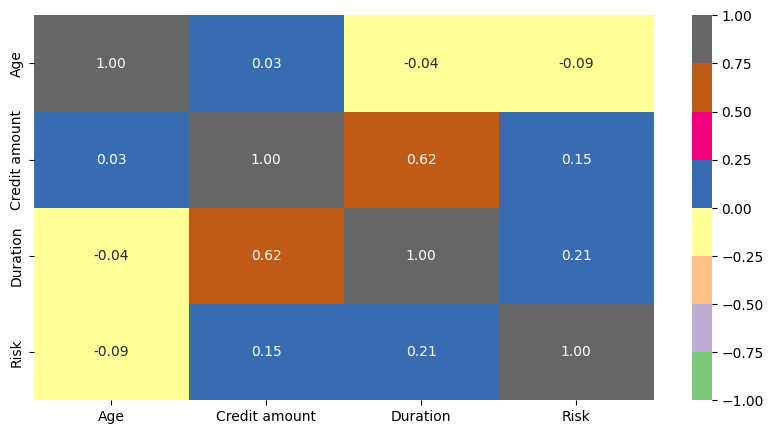

In [19]:
cols_list = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 5))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Accent"
)
plt.show()

**Creating functions that will help us with further analysis.**

In [20]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

***Observations of distribution plot on Age as predictor and Risk as target***

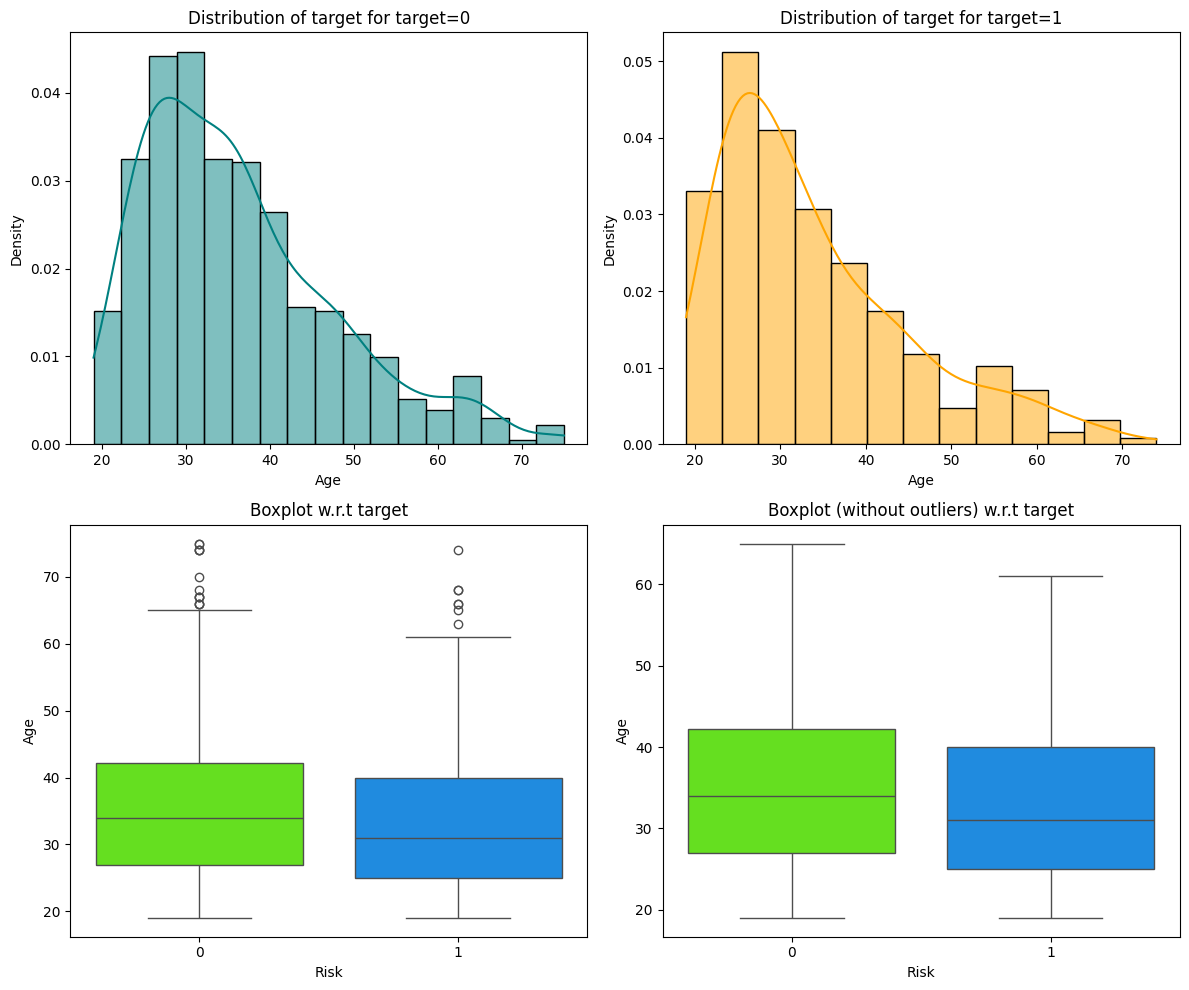

In [21]:
distribution_plot_wrt_target(data, predictor="Age", target="Risk")

***Observations of distribution plot on Credit amount as predictor and Risk as target***

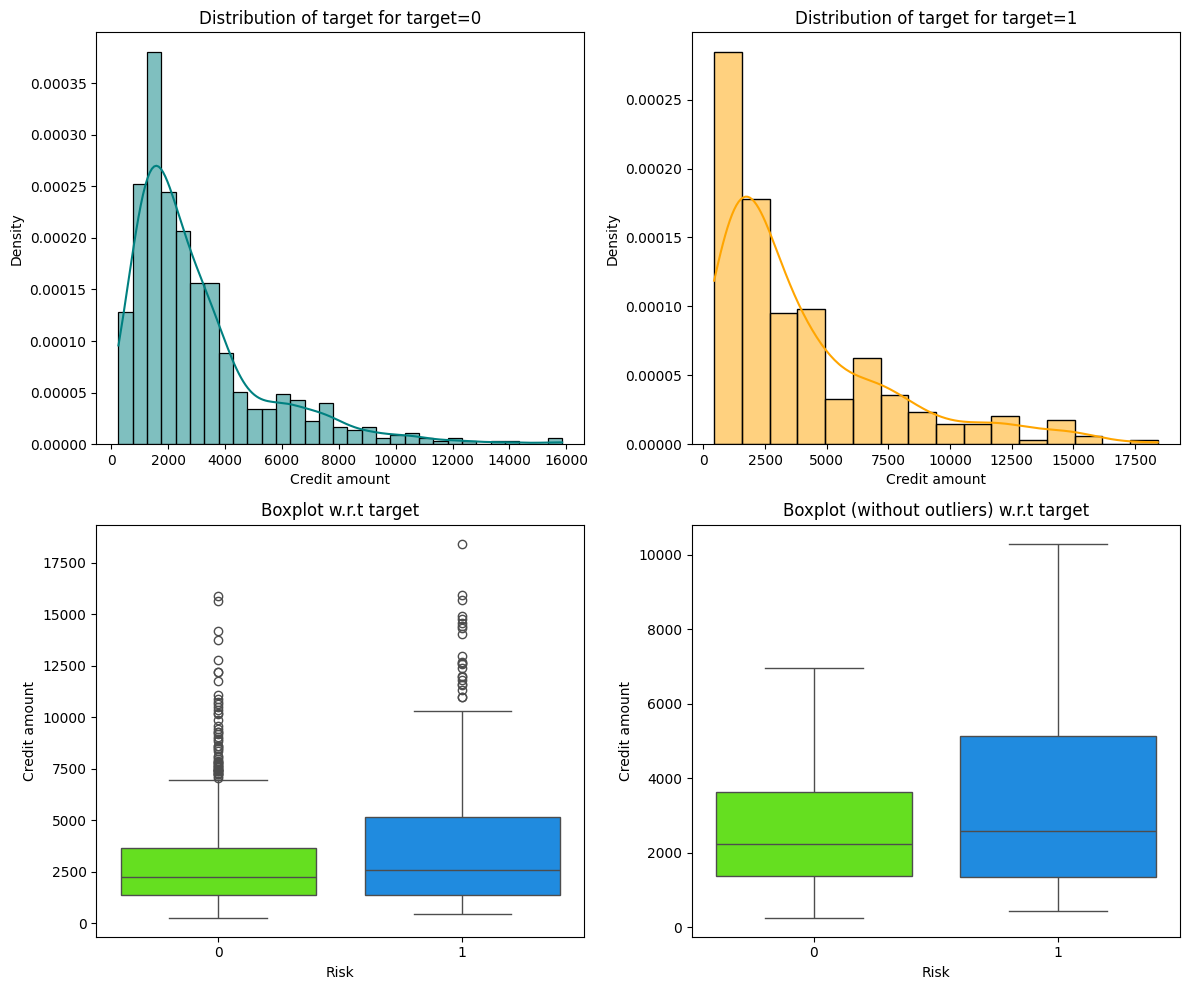

In [22]:
distribution_plot_wrt_target(data, predictor="Credit amount", target="Risk")

***Observations of distribution plot on Duration as predictor and Risk as target***

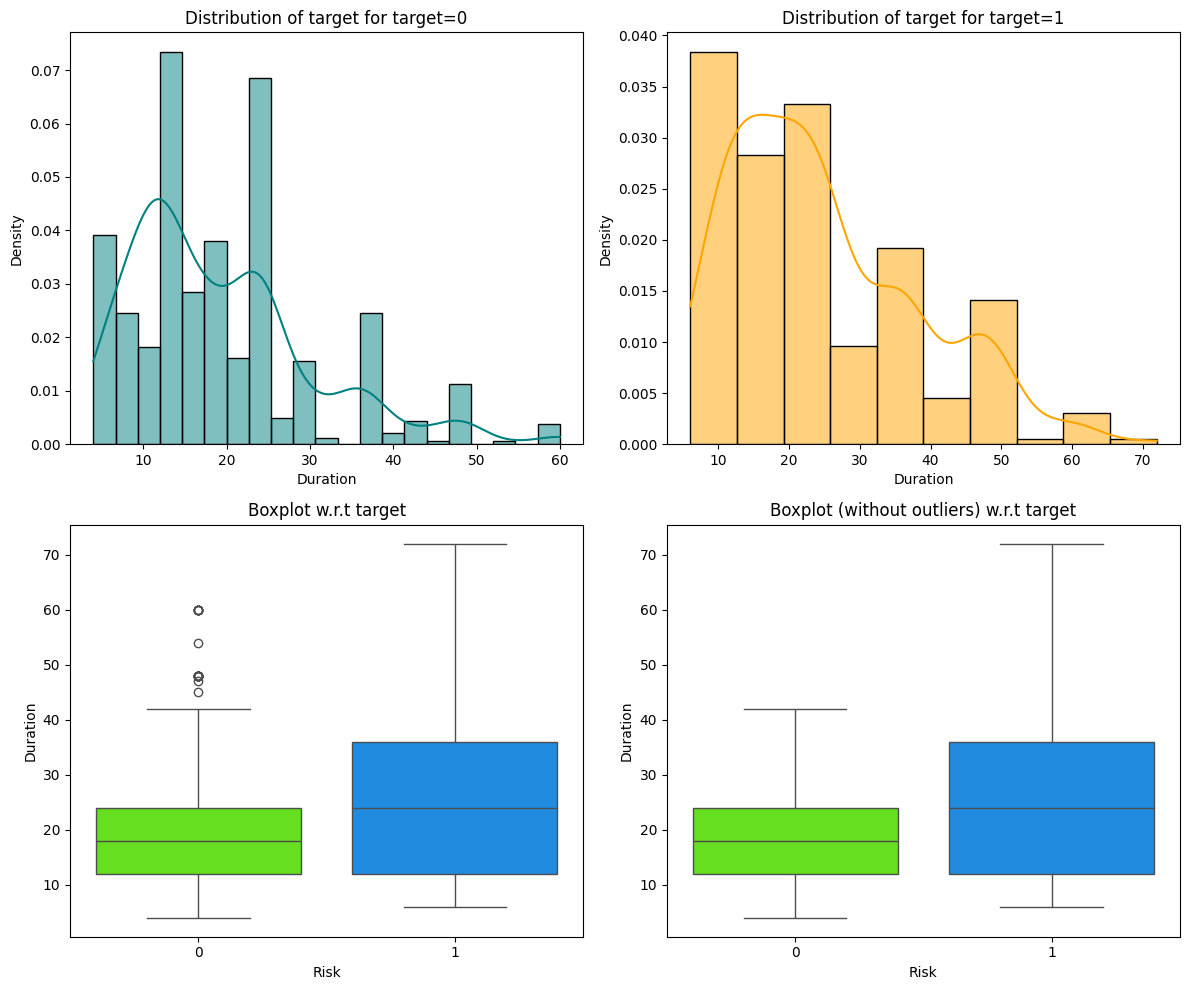

In [23]:
distribution_plot_wrt_target(data, predictor="Duration", target="Risk")

In [24]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

***Observations of stacked_barplot on Job as predictors and Risk as target***

Risk                          0    1   All
Job                                       
All                         700  300  1000
skilled                     444  186   630
unskilled_and_non-resident  159   63   222
highly skilled               97   51   148
------------------------------------------------------------------------------------------------------------------------


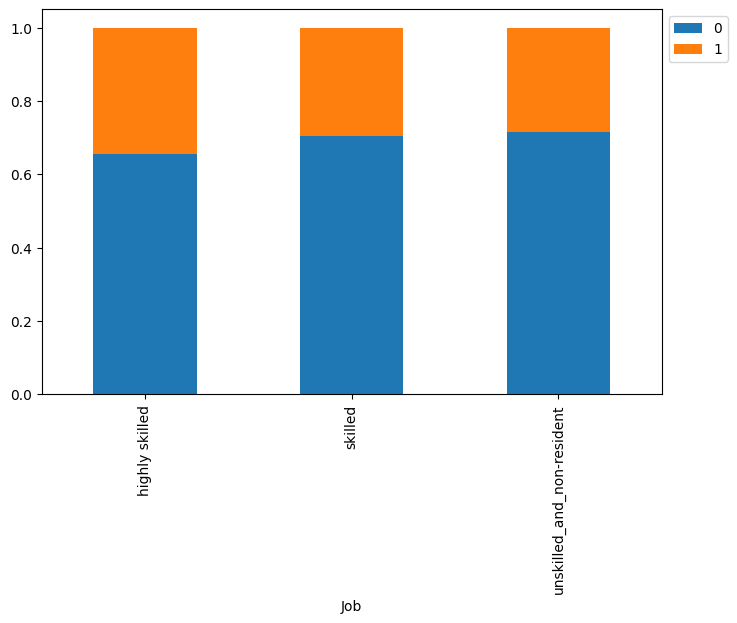

In [25]:
stacked_barplot(data, predictor="Job", target="Risk")

***Observations of stacked_barplot on Housing as predictors and Risk as target***

Risk       0    1   All
Housing                
All      700  300  1000
own      527  186   713
rent     109   70   179
free      64   44   108
------------------------------------------------------------------------------------------------------------------------


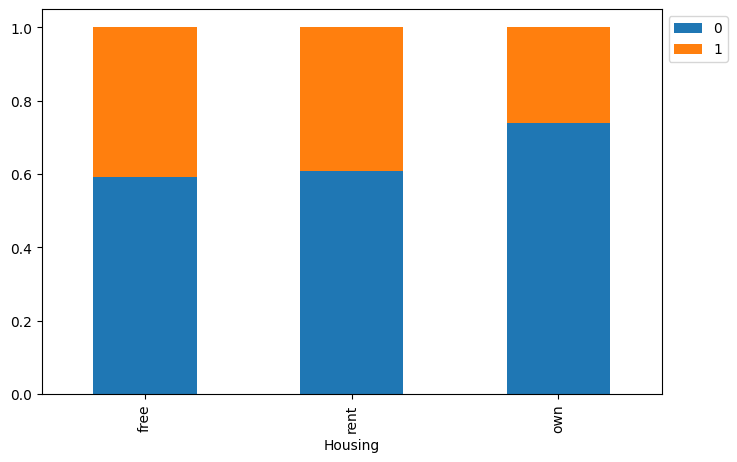

In [26]:
stacked_barplot(data, predictor="Housing", target="Risk")

***Observations of stacked_barplot on Saving accounts as predictors and Risk as target***

Risk               0    1   All
Saving accounts                
All              700  300  1000
little           537  249   786
moderate          69   34   103
quite rich        52   11    63
rich              42    6    48
------------------------------------------------------------------------------------------------------------------------


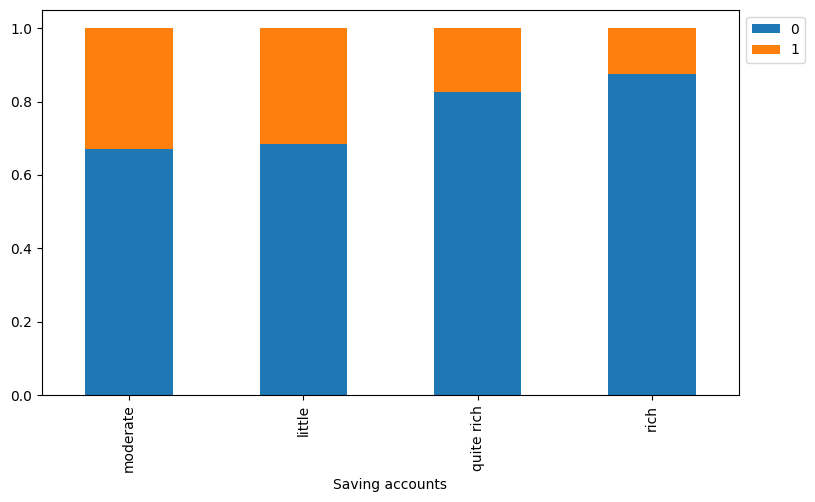

In [27]:
stacked_barplot(data, predictor="Saving accounts", target="Risk")

**compare a numerical feature across the different categories of a categorical feature.**

***Age vs. Sex: To visualize the distribution of Age across Sex categories:***

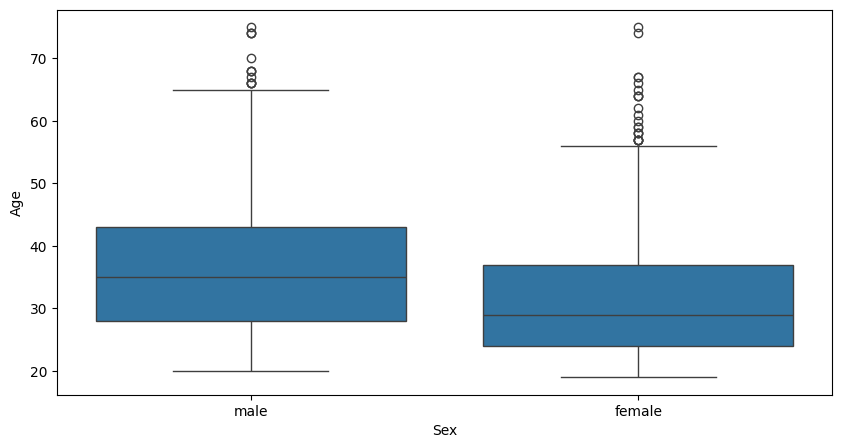

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="Sex", y="Age")
plt.show()

***Credit amount vs. Housing: To visualize the distribution of Credit amount across different housing types:***

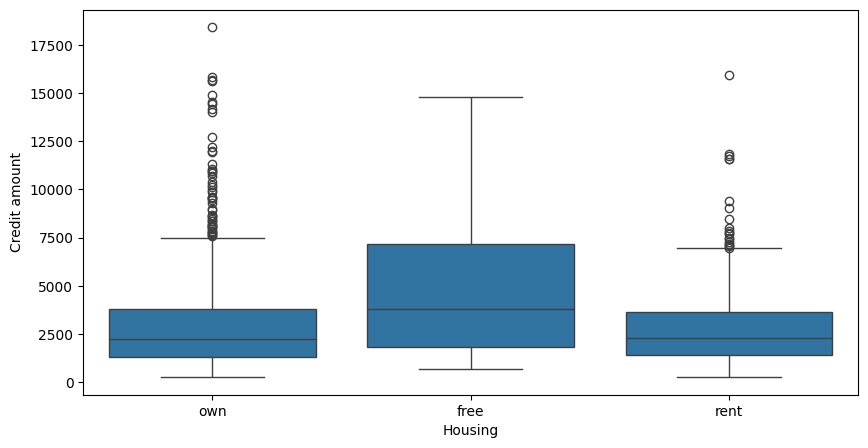

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="Housing", y="Credit amount")
plt.show()

***Duration vs. Job: To visualize how the Duration of credit varies across different Job categories:***

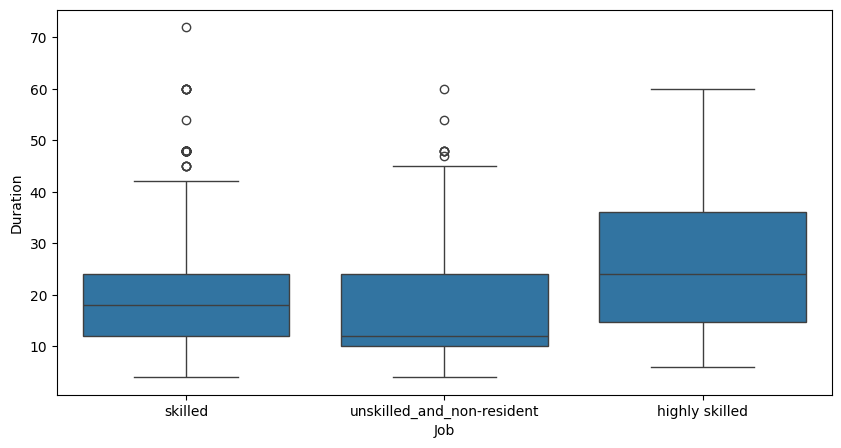

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="Job", y="Duration")
plt.show()

## Data Preposessing

### Outlier check

In [31]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
0,67,male,skilled,own,little,little,1169,6,0,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,1,radio/TV
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
3,45,male,skilled,free,little,little,7882,42,0,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,1,car


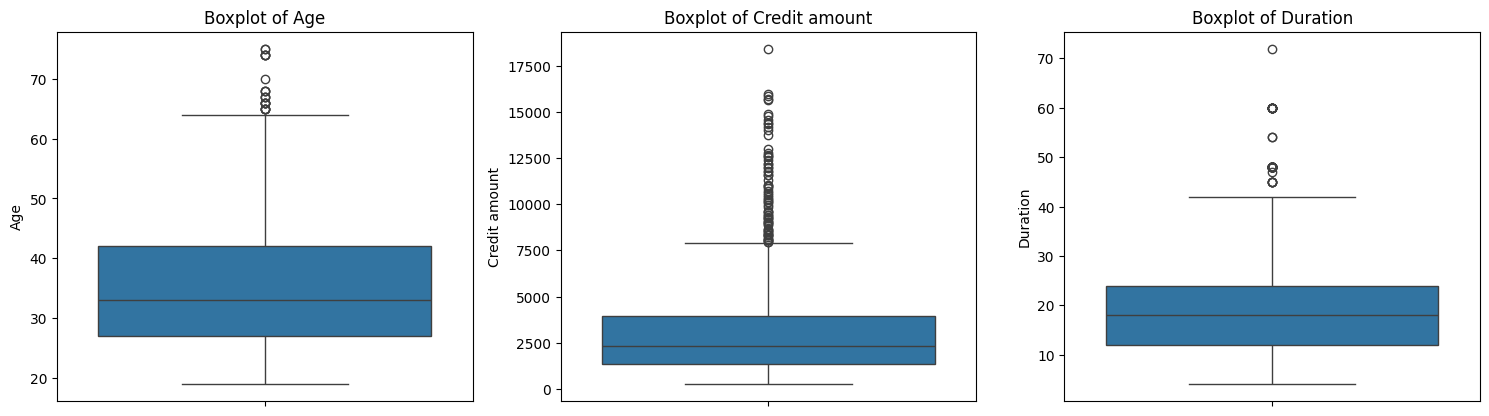

In [32]:
# Selecting numeric columns excluding 'Risk'
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Remove the dependent variable (Risk) from the list of numeric columns
numeric_columns.remove('Risk')  # Adjust the column name to match your dataset

# Plot the boxplots for all numeric columns (except Risk)
plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)  # Adjust the grid size (rows, columns) as needed
    sns.boxplot(data=data, y=variable)
    plt.title(f'Boxplot of {variable}')
    plt.tight_layout()

plt.show()

### Removing outliers from the data using the IQR (Interquartile Range) method.

In [33]:
def remove_outliers(data, columns):
    """
    Removes outliers from the specified columns of the dataframe using the IQR method.

    Parameters:
    data (pd.DataFrame): The dataframe to remove outliers from.
    columns (list): List of columns to check for outliers.

    Returns:
    pd.DataFrame: Dataframe with outliers removed.
    """
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)

        # Calculate the IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    return data

# Selecting numeric columns excluding the target variable 'Risk'
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Ensure the target variable 'Risk' is not included
if 'Risk' in numeric_columns:
    numeric_columns.remove('Risk')

# Remove outliers from the numeric columns
cleaned_data = remove_outliers(data, numeric_columns)

# Print the shape of the cleaned data to check how many rows were removed
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
data = cleaned_data

Original data shape: (1000, 10)
Cleaned data shape: (861, 10)


In [34]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
4,53,male,skilled,free,little,little,4870,24,1,car
6,53,male,skilled,own,quite rich,moderate,2835,24,0,furniture/equipment
7,35,male,highly skilled,rent,little,moderate,6948,36,0,car
8,61,male,unskilled_and_non-resident,own,rich,moderate,3059,12,0,radio/TV


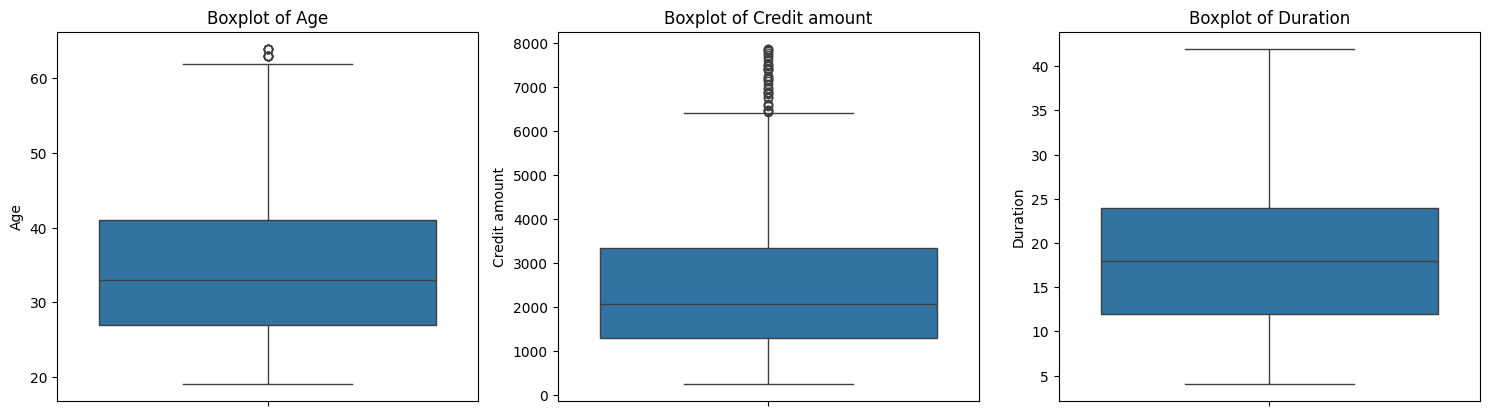

In [35]:
# Selecting numeric columns excluding 'Risk'
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Remove the dependent variable (Risk) from the list of numeric columns
numeric_columns.remove('Risk')  # Adjust the column name to match your dataset

# Plot the boxplots for all numeric columns (except Risk)
plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)  # Adjust the grid size (rows, columns) as needed
    sns.boxplot(data=data, y=variable)
    plt.title(f'Boxplot of {variable}')
    plt.tight_layout()

plt.show()

***Apply log transformation to the Credit amount column***

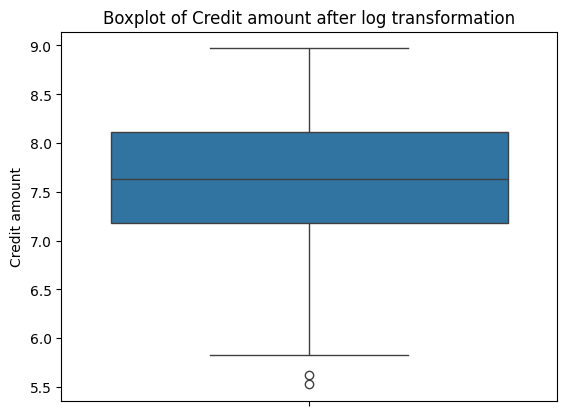

In [36]:
data['Credit amount'] = np.log1p(data['Credit amount'])  # log1p is used to handle zero values

# Plot boxplot again to check the impact of the transformation
sns.boxplot(data=data['Credit amount'])
plt.title('Boxplot of Credit amount after log transformation')
plt.show()

***Final Outier Check***

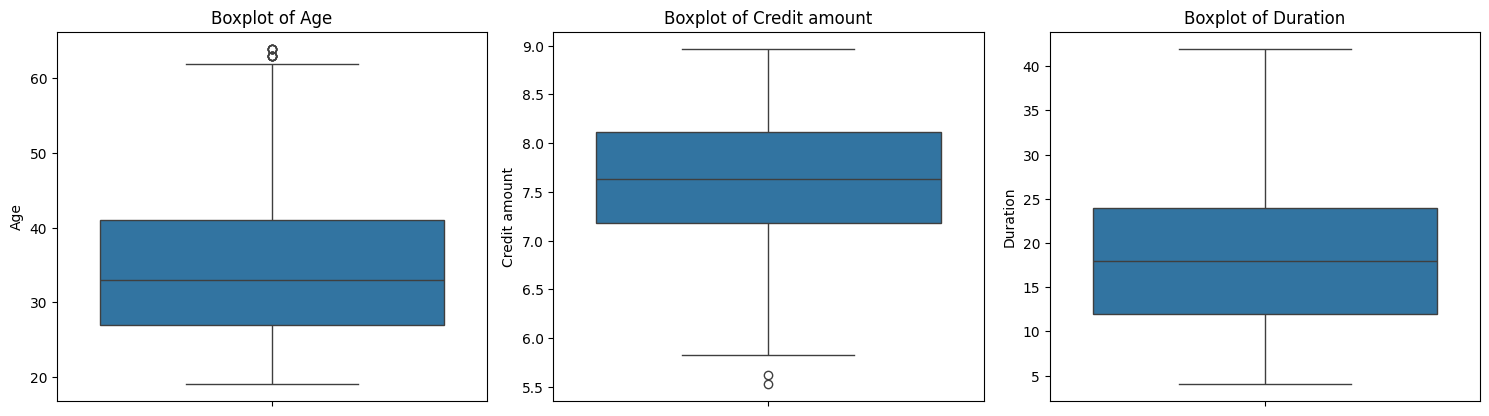

In [37]:
# Selecting numeric columns excluding 'Risk'
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Remove the dependent variable (Risk) from the list of numeric columns
numeric_columns.remove('Risk')  # Adjust the column name to match your dataset

# Plot the boxplots for all numeric columns (except Risk)
plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)  # Adjust the grid size (rows, columns) as needed
    sns.boxplot(data=data, y=variable)
    plt.title(f'Boxplot of {variable}')
    plt.tight_layout()

plt.show()

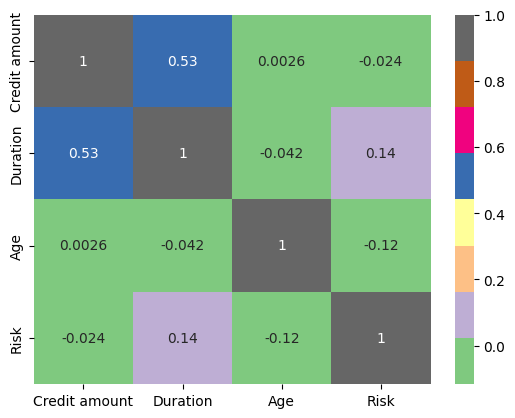

In [38]:
correlation_matrix = data[['Credit amount', 'Duration', 'Age', 'Risk']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Accent')
plt.show()

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861 entries, 2 to 997
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               861 non-null    int64  
 1   Sex               861 non-null    object 
 2   Job               861 non-null    object 
 3   Housing           861 non-null    object 
 4   Saving accounts   861 non-null    object 
 5   Checking account  861 non-null    object 
 6   Credit amount     861 non-null    float64
 7   Duration          861 non-null    int64  
 8   Risk              861 non-null    int64  
 9   Purpose           861 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 74.0+ KB


In [40]:
print(data['Risk'].value_counts())  # Check distribution of the target variable

Risk
0    633
1    228
Name: count, dtype: int64


In [41]:
import pandas as pd

# 1. Label Encoding for binary variables (Sex)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])  # male = 1, female = 0

# 2. One-Hot Encoding for nominal categorical variables (Housing, Purpose, Job)
data = pd.get_dummies(data, columns=['Housing', 'Purpose', 'Job'], drop_first=True)

# 3. Label Encoding (Ordinal Encoding) for ordinal variables (Saving accounts, Checking account)
saving_mapping = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
checking_mapping = {'little': 1, 'moderate': 2, 'rich': 3}

data['Saving accounts'] = data['Saving accounts'].map(saving_mapping)
data['Checking account'] = data['Checking account'].map(checking_mapping)

# 4. Target variable (Risk) is already binary, no changes needed


In [42]:
data.head()

,Age,Sex,Saving accounts,Checking account,Credit amount,Duration,Risk,Housing_own,Housing_rent,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_skilled,Job_unskilled_and_non-resident
2,49,1,1,1,7.648263,12,0,True,False,False,False,True,False,False,False,False,False,True
4,53,1,1,1,8.491055,24,1,False,False,True,False,False,False,False,False,False,True,False
6,53,1,3,2,7.950150,24,0,True,False,False,False,False,True,False,False,False,True,False
7,35,1,1,2,8.846353,36,0,False,True,True,False,False,False,False,False,False,False,False
8,61,1,4,2,8.026170,12,0,True,False,False,False,False,False,True,False,False,False,True


In [43]:
# 1. Define the feature variables (X) and target variable (y)
X = data.drop('Risk', axis=1)  # Features (drop the target column)
Y = data['Risk']  # Target (Risk)

X = pd.get_dummies(X, drop_first=True)  ## Complete the code to create dummies for X

# 2. Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)

# 'test_size=0.3' means 30% of the data will be used for testing, 70% for training
# 'random_state=1' ensures reproducibility (same split every time the code is run)

In [44]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (602, 17)
Shape of test set :  (259, 17)
Percentage of classes in training set:
Risk
0    0.73588
1    0.26412
Name: proportion, dtype: float64
Percentage of classes in test set:
Risk
0    0.733591
1    0.266409
Name: proportion, dtype: float64


In [45]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [46]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree - Model Building and Hyperparameter Tuning

### Decision Tree Model

In [47]:
model = DecisionTreeClassifier(random_state=1) ## Defining the decision tree classifier with random state = 1
model.fit(X_train, y_train) ## fit decision tree classifier on the train data

DecisionTreeClassifier(random_state=1)

#### Checking model performance on training set

In [48]:
y_pred = model.predict(X_train)
print(np.unique(y_pred, return_counts=True)) ## Create confusion matrix for train data

(array([0, 1]), array([443, 159]))


In [49]:
print(confusion_matrix(y_train,y_pred))

[[443   0]
 [  0 159]]


In [50]:
print(y_train.value_counts())

Risk
0    443
1    159
Name: count, dtype: int64


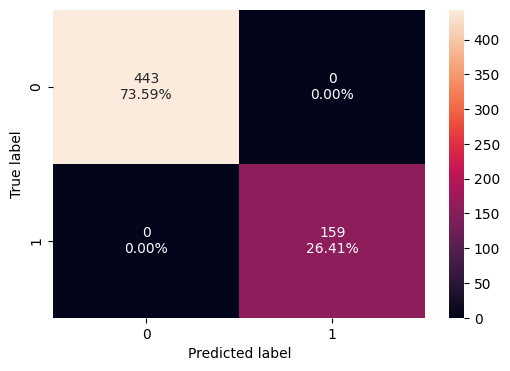

In [51]:
confusion_matrix_sklearn(model, X_train, y_train)

In [52]:
decision_tree_perf_train = model_performance_classification_sklearn(model, X_train, y_train) ## Check performance on train data
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


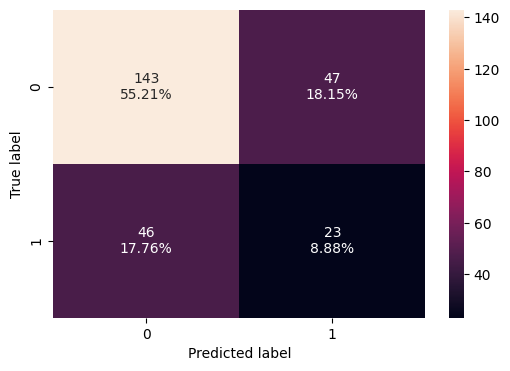

In [53]:
confusion_matrix_sklearn(model,X_test,y_test) ## Create confusion matrix for test data

In [54]:
decision_tree_perf_test = model_performance_classification_sklearn(model,X_test,y_test) ## Check performance for test data
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.640927,0.333333,0.328571,0.330935


### Hyperparameter Tuning - Decision Tree

In [55]:
# Choose the type of classifier.
dtree_estimator = DecisionTreeClassifier(class_weight="balanced", random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(5, 16, 5),
    "min_samples_leaf": [3, 5, 7],
    "max_leaf_nodes": [2, 5],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator,param_grid=parameters,n_jobs=-1,verbose=True) ## Complete the code to run grid search with n_jobs = -1

grid_obj = grid_obj.fit(X_train,y_train) ## Complete the code to fit the grid_obj on the train data

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


DecisionTreeClassifier(class_weight='balanced', max_depth=np.int64(5),
                       max_leaf_nodes=5, min_impurity_decrease=0.0001,
                       min_samples_leaf=3, random_state=1)

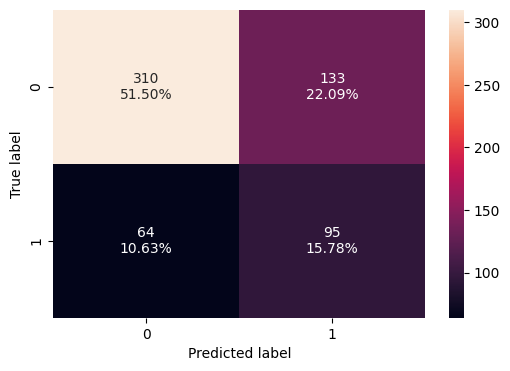

In [56]:
confusion_matrix_sklearn(dtree_estimator,X_train,y_train) ## Complete the code to create confusion matrix for train data on tuned estimator

In [57]:
dtree_estimator_model_train_perf = model_performance_classification_sklearn(dtree_estimator,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
dtree_estimator_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.672757,0.597484,0.416667,0.490956


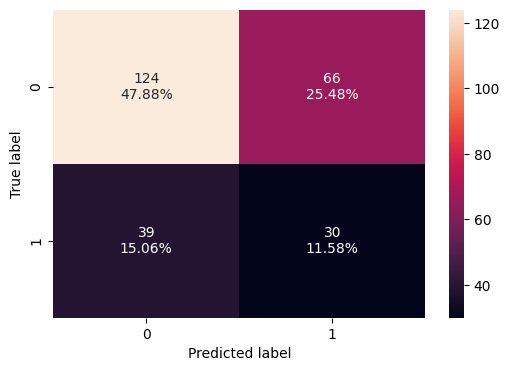

In [58]:
confusion_matrix_sklearn(dtree_estimator,X_test,y_test) ## Complete the code to create confusion matrix for test data on tuned estimator

In [59]:
dtree_estimator_model_test_perf = model_performance_classification_sklearn(dtree_estimator,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
dtree_estimator_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.594595,0.434783,0.3125,0.363636


### Hyperparameter Tuning - Decision Tree

In [60]:
# Choose the type of classifier.
dtree_estimator = DecisionTreeClassifier(class_weight="balanced", random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(5, 16, 5),
    "min_samples_leaf": [3, 5, 7],
    "max_leaf_nodes": [2, 5],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator,param_grid=parameters,n_jobs=-1,verbose=True) ## Complete the code to run grid search with n_jobs = -1

grid_obj = grid_obj.fit(X_train,y_train) ## Complete the code to fit the grid_obj on the train data

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


DecisionTreeClassifier(class_weight='balanced', max_depth=np.int64(5),
                       max_leaf_nodes=5, min_impurity_decrease=0.0001,
                       min_samples_leaf=3, random_state=1)

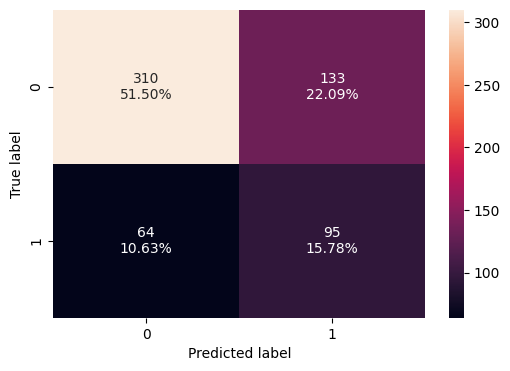

In [61]:
confusion_matrix_sklearn(dtree_estimator,X_train,y_train) ## Complete the code to create confusion matrix for train data on tuned estimator

In [62]:
dtree_estimator_model_train_perf = model_performance_classification_sklearn(dtree_estimator,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
dtree_estimator_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.672757,0.597484,0.416667,0.490956


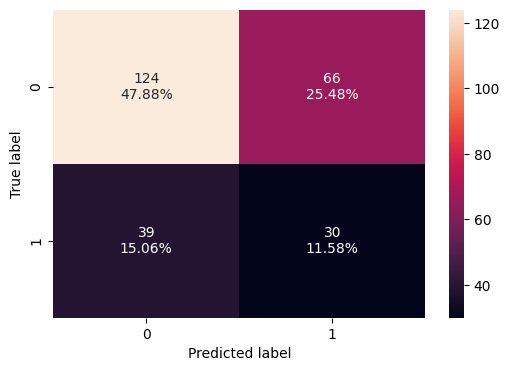

In [63]:
confusion_matrix_sklearn(dtree_estimator,X_test,y_test) ## Complete the code to create confusion matrix for test data on tuned estimator

In [64]:
dtree_estimator_model_test_perf = model_performance_classification_sklearn(dtree_estimator,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
dtree_estimator_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.594595,0.434783,0.3125,0.363636


## Bagging - Model Building and Hyperparameter Tuning

### Bagging classifier

In [65]:
bagging_classifier = BaggingClassifier() ## Complete the code to define bagging classifier with random state = 1
bagging_classifier.fit(X_train,y_train) ## Complete the code to fit bagging classifier on the train data

BaggingClassifier()

#### Checking model performance on training set

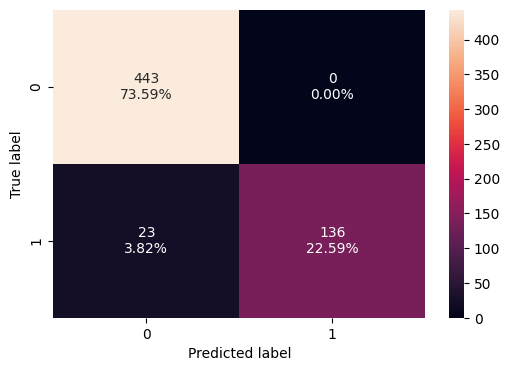

In [66]:
confusion_matrix_sklearn(bagging_classifier,X_train,y_train)## Complete the code to create confusion matrix for train data

In [67]:
bagging_classifier_model_train_perf = model_performance_classification_sklearn(bagging_classifier,X_train,y_train) ## Complete the code to check performance on train data
bagging_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.961794,0.855346,1.0,0.922034


#### Checking model performance on test set

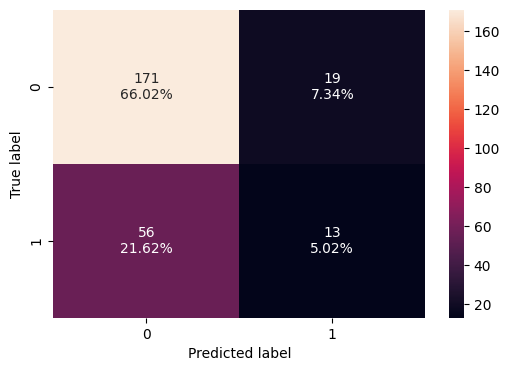

In [68]:
confusion_matrix_sklearn(bagging_classifier,X_test,y_test) ## Complete the code to create confusion matrix for test data

In [69]:
bagging_classifier_model_test_perf = model_performance_classification_sklearn(bagging_classifier,X_test,y_test) ## Complete the code to check performance for test data
bagging_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.710425,0.188406,0.40625,0.257426


### Hyperparameter Tuning - Bagging Classifier

In [70]:
# Choose the type of classifier.
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_samples": [0.7, 0.9],
    "max_features": [0.7, 0.9],
    "n_estimators": np.arange(90, 111, 10),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned,param_grid=parameters,cv=5,verbose=True) ## Run grid search with cv = 5
grid_obj = grid_obj.fit(X_train,y_train) ## Fit the grid_obj on train data

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=np.int64(90),
                  random_state=1)

#### Checking model performance on training set

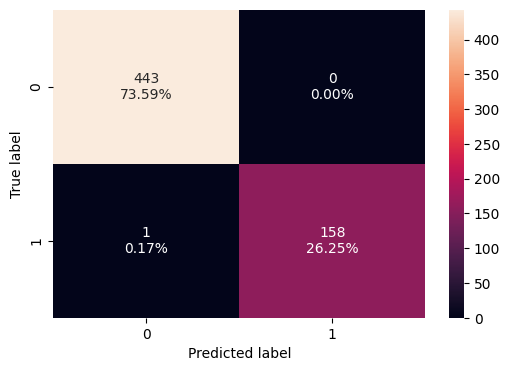

In [71]:
confusion_matrix_sklearn(bagging_estimator_tuned,X_train,y_train) ## create confusion matrix for train data on tuned estimator

In [72]:
bagging_estimator_tuned_model_train_perf = model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
bagging_estimator_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.998339,0.993711,1.0,0.996845


#### Checking model performance on test set

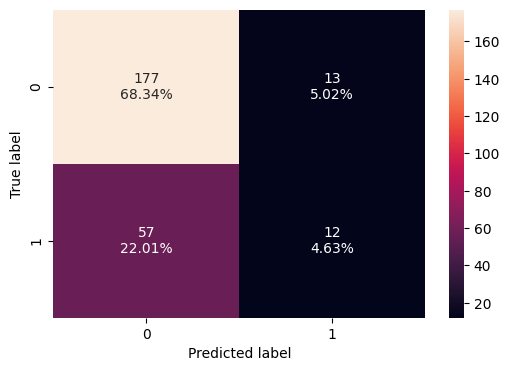

In [73]:
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

In [74]:
bagging_estimator_tuned_model_test_perf = model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
bagging_estimator_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.72973,0.173913,0.48,0.255319


### Random Forest

In [75]:
# Fitting the model
rf_estimator = RandomForestClassifier() ## Complete the code to define random forest with random state = 1 and class_weight = balanced
rf_estimator.fit(X_train,y_train) ## Complete the code to fit random forest on the train data

RandomForestClassifier()

#### Checking model performance on training set

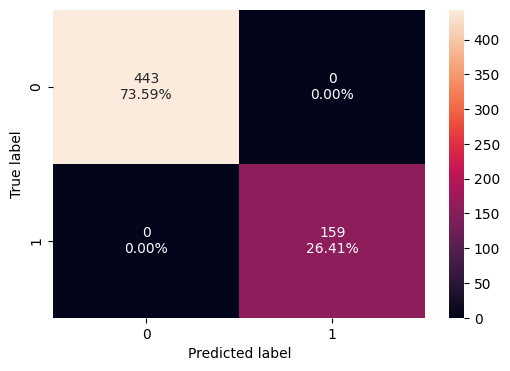

In [76]:
confusion_matrix_sklearn(rf_estimator,X_train,y_train) ## Complete the code to create confusion matrix for train data

In [77]:
# Calculating different metrics
rf_estimator_model_train_perf = model_performance_classification_sklearn(rf_estimator,X_train,y_train) ## Complete the code to check performance on train data
rf_estimator_model_train_perf

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


#### Checking model performance on test set

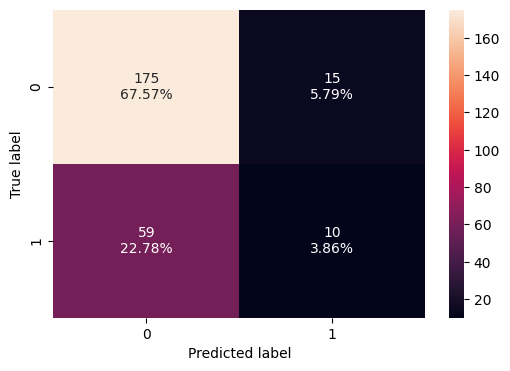

In [78]:
confusion_matrix_sklearn(rf_estimator,X_test,y_test) ## Complete the code to create confusion matrix for test data

In [79]:
rf_estimator_model_test_perf = model_performance_classification_sklearn(rf_estimator,X_test,y_test) ## Complete the code to check performance for test data
rf_estimator_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.714286,0.144928,0.4,0.212766


### Hyperparameter Tuning - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

# Choose the type of classifier with OOB scoring enabled
# Increased n_estimators for better OOB estimates
rf_tuned = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

# Adjusting the parameter grid with a higher number of trees (n_estimators)
parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 7],
    "n_estimators": np.arange(100, 201, 50)  # Increased range of trees to avoid OOB score warning
}

# Define scoring method
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search with cross-validation (cv=5) and parallel jobs (n_jobs=-1)
grid_obj = GridSearchCV(rf_tuned, param_grid=parameters, n_jobs=-1, cv=5, verbose=True)  # Grid search with cross-validation
grid_obj = grid_obj.fit(X_train, y_train)  # Fit the grid search on the training data

# Set rf_tuned to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# No need to refit the model, since GridSearchCV has already done that
# rf_tuned.fit(X_train, y_train)  -- Redundant after GridSearchCV fitting


Fitting 5 folds for each of 24 candidates, totalling 120 fits


#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(rf_tuned,X_train,y_train) ## Complete the code to create confusion matrix for train data on tuned estimator

In [ ]:
rf_tuned_model_train_perf = model_performance_classification_sklearn(rf_tuned,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
rf_tuned_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(rf_tuned,X_test,y_test) ## Complete the code to create confusion matrix for test data on tuned estimator

In [ ]:
rf_tuned_model_test_perf = model_performance_classification_sklearn(rf_tuned,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
rf_tuned_model_test_perf

## Boosting - Model Building and Hyperparameter Tuning

### AdaBoost Classifier

In [ ]:
ab_classifier = AdaBoostClassifier() ## Complete the code to define AdaBoost Classifier with random state = 1
ab_classifier.fit(X_train,y_train)## Complete the code to fit AdaBoost Classifier on the train data

#### Checking model performance on training set

confusion_matrix_sklearn(ab_classifier,X_train,y_train) ## Complete the code to create confusion matrix for train data

In [ ]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,X_train,y_train) ## Complete the code to check performance on train data
ab_classifier_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(ab_classifier,X_test,y_test) ## Complete the code to create confusion matrix for test data

In [ ]:
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,X_test,y_test) ## Complete the code to check performance for test data
ab_classifier_model_test_perf

### Hyperparameter Tuning - AdaBoost Classifier

In [ ]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    # Let's try different max_depth for base_estimator

    "n_estimators": np.arange(80, 101, 10),
    "learning_rate": np.arange(0.1, 0.4, 0.1),
}

# Type of scoring used to compare parameter  combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned,param_grid=parameters,cv=5,verbose=True) ## Complete the code to run grid search with cv = 5
grid_obj = grid_obj.fit(X_train,y_train) ## Complete the code to fit the grid_obj on train data

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(abc_tuned,X_train,y_train) ## Complete the code to create confusion matrix for train data on tuned estimator

In [ ]:
abc_tuned_model_train_perf = model_performance_classification_sklearn(abc_tuned,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
abc_tuned_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(abc_tuned,X_test,y_test) ## Complete the code to create confusion matrix for test data on tuned estimator

In [ ]:
abc_tuned_model_test_perf = model_performance_classification_sklearn(abc_tuned,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
abc_tuned_model_test_perf

### Gradient Boosting Classifier

In [ ]:
gb_classifier = GradientBoostingClassifier() ## Complete the code to define Gradient Boosting Classifier with random state = 1
gb_classifier.fit(X_train,y_train) ## Complete the code to fit Gradient Boosting Classifier on the train data

#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(gb_classifier,X_train,y_train) ## Complete the code to create confusion matrix for train data

In [ ]:
gb_classifier_model_train_perf = model_performance_classification_sklearn(gb_classifier,X_train,y_train) ## Complete the code to check performance on train data
gb_classifier_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(gb_classifier,X_test,y_test) ## Complete the code to create confusion matrix for test data

In [ ]:
gb_classifier_model_test_perf = model_performance_classification_sklearn(gb_classifier,X_test,y_test) ## Complete the code to check performance for test data
gb_classifier_model_test_perf

### Hyperparameter Tuning - Gradient Boosting Classifier

In [ ]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(
    init=AdaBoostClassifier(random_state=1), random_state=1
)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [200, 250],
    "subsample": [0.9, 1],
    "max_features": [0.8, 0.9],
    "learning_rate": np.arange(0.1, 0.21, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned,param_grid=parameters,cv=5,verbose=True) ## Complete the code to run grid search with cv = 5
grid_obj = grid_obj.fit(X_train,y_train) ## Complete the code to fit the grid_obj on train data

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(gbc_tuned,X_train,y_train)## Complete the code to create confusion matrix for train data on tuned estimator

In [ ]:
gbc_tuned_model_train_perf = model_performance_classification_sklearn(gbc_tuned,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
gbc_tuned_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)## Complete the code to create confusion matrix for test data on tuned estimator

In [ ]:
gbc_tuned_model_test_perf = model_performance_classification_sklearn(gbc_tuned,X_test,y_test) ## Complete the code to check performance for test data on tuned estimator
gbc_tuned_model_test_perf

### Note - You can choose **not to build** XGBoost if you have any installation issues

### XGBoost Classifier

In [ ]:
xgb_classifier = XGBClassifier() ## Complete the code to define XGBoost Classifier with random state = 1 and eval_metric="logloss"
xgb_classifier.fit(X_train,y_train) ## Complete the code to fit XGBoost Classifier on the train data

#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(xgb_classifier,X_train,y_train) ## Complete the code to create confusion matrix for train data

In [ ]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb_classifier,X_train,y_train) ## Complete the code to check performance on train data
xgb_classifier_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(xgb_classifier,X_test,y_test) ## Complete the code to create confusion matrix for test data

In [ ]:
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb_classifier,X_test,y_test) ## Complete the code to check performance for test data
xgb_classifier_model_test_perf

### Hyperparameter Tuning - XGBoost Classifier

In [ ]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1, eval_metric="logloss")

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(150, 250, 50),
    "scale_pos_weight": [1, 2],
    "subsample": [0.9, 1],
    "learning_rate": np.arange(0.1, 0.21, 0.1),
    "gamma": [3, 5],
    "colsample_bytree": [0.8, 0.9],
    "colsample_bylevel": [ 0.9, 1],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned,param_grid=parameters,cv=5,verbose=True) ## Complete the code to run grid search with cv = 5
grid_obj = grid_obj.fit(X_train,y_train) ## Complete the code to fit the grid_obj on train data

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

#### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(xgb_tuned,X_train,y_train)## Complete the code to create confusion matrix for train data on tuned estimator

In [ ]:
xgb_tuned_model_train_perf = model_performance_classification_sklearn(xgb_tuned,X_train,y_train) ## Complete the code to check performance for train data on tuned estimator
xgb_tuned_model_train_perf

#### Checking model performance on test set

In [ ]:
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)## Complete the code to create confusion matrix for test data on tuned estimator

In [ ]:
xgb_tuned_model_test_perf = model_performance_classification_sklearn(xgb_tuned,X_test,y_test)## Complete the code to check performance for test data on tuned estimator
xgb_tuned_model_test_perf

## Stacking Classifier

In [ ]:
estimators = [
    ("AdaBoost", ab_classifier),
    ("Gradient Boosting", gbc_tuned),
    ("Random Forest", rf_tuned),
]

final_estimator = xgb_tuned

stacking_classifier = StackingClassifier(estimators=estimators,final_estimator=final_estimator) ## Complete the code to define Stacking Classifier

stacking_classifier.fit(X_train,y_train)#.score(X_test,y_test) ## Complete the code to fit Stacking Classifier on the train data

### Checking model performance on training set

In [ ]:
confusion_matrix_sklearn(stacking_classifier,X_train,y_train)## Complete the code to create confusion matrix for train data

In [ ]:
stacking_classifier_model_train_perf = model_performance_classification_sklearn(stacking_classifier,X_train,y_train) ## Complete the code to check performance on train data
stacking_classifier_model_train_perf

### Checking model performance on test set

In [ ]:
stacking_classifier_model_test_perf = model_performance_classification_sklearn(stacking_classifier,X_test,y_test) ## Complete the code to check performance for test data
stacking_classifier_model_test_perf

## Model Performance Comparison and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train.T,
        dtree_estimator_model_train_perf.T,
        bagging_classifier_model_train_perf.T,
        bagging_estimator_tuned_model_train_perf.T,
        rf_estimator_model_train_perf.T,
        rf_tuned_model_train_perf.T,
        ab_classifier_model_train_perf.T,
        abc_tuned_model_train_perf.T,
        gb_classifier_model_train_perf.T,
        gbc_tuned_model_train_perf.T,
        xgb_classifier_model_train_perf.T,
        xgb_tuned_model_train_perf.T,
        stacking_classifier_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Training performance comparison:")
models_train_comp_df

In [ ]:
# testing performance comparison

stacking_classifier.score(X_test,y_test) ## Complete the code to check performance for test data

In [ ]:
feature_names = X_train.columns
importances = gb_classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Model Performance Analysis and Insights

### Key Insights

1. **Accuracy**:
   - The **Random Forest**, **Decision Tree**, and **XGBoost** classifiers achieve perfect accuracy (1.0), indicating that these models have fully captured the training data without errors.
   - The **Tuned Gradient Boosting** and **Bagging Classifier** models also perform well with high accuracy scores (0.945 and 0.998, respectively), showing that they are robust classifiers.

2. **Recall**:
   - **Random Forest**, **Decision Tree**, and **XGBoost** models exhibit perfect recall (1.0), meaning they effectively identify all instances of loan defaulters.
   - The **Tuned Random Forest** model has a notably low recall score (0.125), suggesting it fails to identify many defaulters, which could be due to overfitting or inadequate model tuning.

3. **Precision**:
   - **Decision Tree**, **Random Forest**, and **XGBoost** achieve perfect precision (1.0), indicating that when these models predict a loan applicant is at risk, their predictions are highly reliable.
   - In contrast, the **Tuned Decision Tree** has a low precision score (0.416), indicating a higher rate of false positives, which could lead to unnecessary loan rejections.

4. **F1-Score**:
   - The **F1-Score**, which balances precision and recall, is highest for the **Random Forest**, **Decision Tree**, and **XGBoost** models (1.0). These models offer the best balance between identifying defaulters and minimizing false positives.
   - The **Tuned Random Forest** shows a significantly lower F1-score (0.223), reflecting its poor balance between precision and recall.
   - The **Tuned Gradient Boosting** and **Bagging Classifiers** show improved F1-scores compared to other tuned models, suggesting that tuning has enhanced their performance to some extent.

### Recommendations

- **Random Forest** and **XGBoost** are recommended for deployment as they achieve high accuracy, recall, and precision. They are effective in identifying defaulters while minimizing the risk of false positives, making them suitable for loan approval decisions.
- **Tuned Random Forest** and **Tuned Adaboost Classifier** should be reconsidered or further tuned due to their poor recall. These models are missing many defaulters, which could lead to missed risk identification. Additional tuning or alternative models may be needed to improve their performance.
- The **Bagging Classifier**, especially in its tuned form, shows a strong balance between accuracy and recall. This model could be a robust choice for practical implementation, providing a good trade-off between correctly identifying defaulters and minimizing errors.
- **Tuned Decision Tree** models are less effective, as indicated by their decreased F1-scores and recall. It may be beneficial to explore other models or additional tuning techniques to enhance their performance.

### Conclusion

For this task, **Random Forest**, **XGBoost**, and **Bagging Classifiers** emerge as the most effective models for predicting loan approval risk. Their high performance across accuracy, recall, and precision metrics makes them suitable for use in decision-making processes. Further investigation and tuning may be necessary for models with lower performance to ensure optimal results and mitigate potential risks.
